## RNN on IMDB Dataset:

Coursera Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%203%20-%20Lesson%202d.ipynb

IMDB Review dataset: http://ai.stanford.edu/~amaas/data/sentiment/

converting tensors to numpy arrays: https://www.tensorflow.org/tutorials/customization/basics

Embedding in TF/Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

To visualise (projector) the embeddings and see the sentiment: http://projector.tensorflow.org/

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.2.0-rc1


In [0]:
# Import TF dataset

# if we have to download the TF datasets:
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds

# Load imdb review ds available in tf:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete01ULWY/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete01ULWY/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete01ULWY/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [0]:
type(imdb)
print(list(imdb)[:10])
print(list(imdb))

['test', 'train', 'unsupervised']
['test', 'train', 'unsupervised']


# Converting a tensor ds to list of strings for sentence data and to arrays for label data -> to make it ready for a NN trainer.

In [0]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

print(train_data)  # data is stored in a tensor of two columns: col 1 are the texts and col 2 the labels!
print(test_data)

# tf.print(train_data, output_stream=sys.stderr)
# print(str(train_data.eval()))

# The datasets in TF are stored in tensors. 
# Thus, we have to convert them to list of strings:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# The .numpy() method explicitly converts a Tensor to a numpy array
for s,l in train_data :  # s picks up the first col of the tensor, l picks up the second
  training_sentences.append(str(s.numpy()))  # s is a tensor column -> it needs to be converted to array using numpy -> and then convert to a string using str -> and we add it to the list uisng append
  training_labels.append(l.numpy())  # labels can stay as array of integers, no need to convert to str.

for s,l in test_data :  # s picks up the first col of the tensor, l picks up the second
  testing_sentences.append(str(s.numpy()))  # s is a tensor column -> it needs to be converted to array using numpy -> and then convert to a string using str -> and we add it to the list uisng append
  testing_labels.append(l.numpy())  # labels can stay as array of integers, no need to convert to str.
 
# the NN model needs a numpy array as labels, thus we convert the list of labels into np array (using np.array()):
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


print(training_sentences[0])
print(len(training_sentences))

print(training_labels_final[0])
print(len(training_labels_final))

print(testing_sentences[0])
print(len(testing_sentences))

print(testing_labels_final[0])
print(len(testing_labels_final))

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
25000
0
25000
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MA

## Vocabulary, Tokenizing and Padding the texts:

In [0]:
vocab_size = 10000
oov_tok = '<OOV>'

max_length = 120
trunc_type = 'post'

embedding_dim = 16


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Building the Vocabulary
tokeniser = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokeniser.fit_on_texts(training_sentences)
word_index = tokeniser.word_index

# Building Sequences and Padding for the training strings/sentences
train_sequences = tokeniser.texts_to_sequences(training_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# Building Sequences and Padding for the testing strings/sentences
# the test sequences are tokenised using the word_index built from the training data
test_sequences = tokeniser.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

In [0]:
sentence = "I really think this is amazing. honest."
sequence = tokeniser.texts_to_sequences(sentence)
print(sequence)

[[11], [], [1431], [966], [4], [1537], [1537], [4715], [], [790], [2019], [11], [2929], [2184], [], [790], [2019], [11], [579], [], [11], [579], [], [4], [1782], [4], [4517], [11], [2929], [1275], [], [], [2019], [1003], [2929], [966], [579], [790], []]


## **DNN** with Embedding and Flatten

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                             tf.keras.layers.Flatten(),  # in this case, after Embedding we can also use GlobalAveragePool1D
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')  # it's a binary classification problem
])

model.summary()


from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.99
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()


model.fit(train_padded, training_labels_final, epochs=10, callbacks=[callback], validation_data=(test_padded, testing_labels_final), verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 8s 336us/sample - loss: 0.4860 - accuracy: 0.7494 - val_loss: 0.3880 - val_accuracy: 0.8244
Epoch 2/10
25000/25000 [==============================] - 7s 267us/sample - loss: 0.2443 - accuracy: 0.9032 - val_loss: 0.4097 - val_accuracy: 0.8228
Epoch 3/10
25000/25000 [==============================] - 6s 248us/sample - loss: 0.1030 - accuracy: 0.9721 - val_loss: 0.5009 - val_accuracy: 0.8132
Epoch 4/10
25000/25000 [==============================] - 6s 238us/sample - loss: 0.0286 - accuracy: 0.9962 - val_loss: 0.5951 - val_accuracy: 0.8074


## Visualising the Embedding into a Projector to look at the Sentiment

In [0]:
# Layer weights of the Embedding layer (it's layer 0):

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [0]:
# This is a function that reverst the word index from an index to a word:

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(train_padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [0]:
# To create the vectors to visualise in the embedding projector:

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
## The vector data will be downloaded

try:
  from google.colab import files
except ImportError:
  pass
else:
  # command to download files from Colab to my pc:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## **DNN** with Embedding and GlobalAveragePool1D

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),  # in this case, after Embedding we can use Flatten too
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')  # it's a binary classification problem
])

model.summary()


from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.99
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()


history = model.fit(train_padded, training_labels_final, epochs=10, callbacks=[callback], validation_data=(test_padded, testing_labels_final), verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 7s 269us/sample - loss: 0.6004 - accuracy: 0.7046 - val_loss: 0.5006 - val_accuracy: 0.8092
Epoch 2/10
25000/25000 [==============================] - 6s 245us/sample - loss: 0.4120 - accuracy: 0.8591 - val_loss: 0.4185 - val_accuracy: 0.8346
Epoch 3/10
25000/25000 [==============================] - 6s 244us/sample - loss: 0.3200 - accuracy: 0.8917 - val_loss: 0.3976 - val_accuracy: 0.8326
Epoch 4/10
25000/25000 [==============================] - 6s 258us/sample - loss: 0.2650 - accuracy: 0.9124 - val_loss: 0.4052 - val_accuracy: 0.8260
Epoch 5/10
25000/25000 [==============================] - 6s 247us/sample - loss: 0.2290 - accuracy: 0.9255 - val_loss: 0.4268 - val_accuracy: 0.8178
Epoch 6/10
25000/25000 [==============================] - 6s 248us/sample - loss: 0.2023 - accuracy: 0.9355 - val_loss: 0.4527 - val_accuracy: 0.8178
Epoch 7/10
25000/25000 [==========================

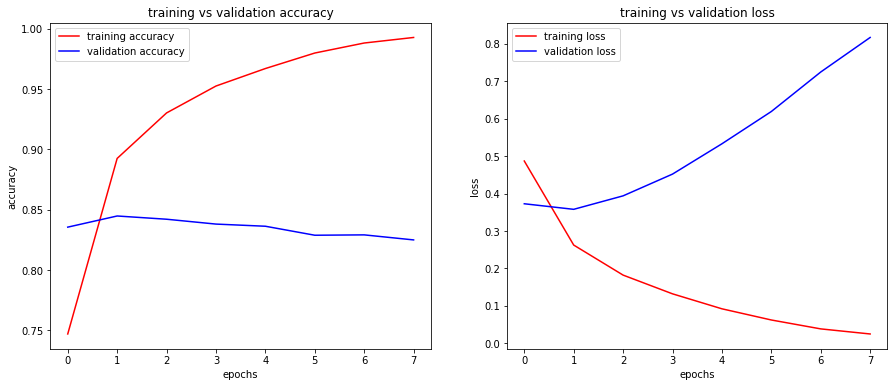

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()

## **GRU RNN** with Embedding 

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),  # Bidirectional GRU of 32 'time-steps' -> this will give 128 units because it's bidirectional.  No need to flatten afterwards!!!
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')  # it's a binary classification problem
])

model.summary()


from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.99
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()


history = model.fit(train_padded, training_labels_final, epochs=10, callbacks=[callback], validation_data=(test_padded, testing_labels_final), verbose=2)

Epoch 1/10
782/782 - 14s - loss: 0.5981 - accuracy: 0.6443 - val_loss: 0.4197 - val_accuracy: 0.8114
Epoch 2/10
782/782 - 14s - loss: 0.3306 - accuracy: 0.8645 - val_loss: 0.3990 - val_accuracy: 0.8276
Epoch 3/10
782/782 - 14s - loss: 0.2498 - accuracy: 0.9052 - val_loss: 0.4252 - val_accuracy: 0.8136
Epoch 4/10
782/782 - 13s - loss: 0.1928 - accuracy: 0.9296 - val_loss: 0.5018 - val_accuracy: 0.8112
Epoch 5/10
782/782 - 14s - loss: 0.1537 - accuracy: 0.9458 - val_loss: 0.5401 - val_accuracy: 0.8122
Epoch 6/10
782/782 - 13s - loss: 0.1179 - accuracy: 0.9597 - val_loss: 0.5910 - val_accuracy: 0.7974
Epoch 7/10
782/782 - 13s - loss: 0.0891 - accuracy: 0.9700 - val_loss: 0.6586 - val_accuracy: 0.7933
Epoch 8/10
782/782 - 14s - loss: 0.0608 - accuracy: 0.9813 - val_loss: 0.7937 - val_accuracy: 0.7955
Epoch 9/10
782/782 - 14s - loss: 0.0484 - accuracy: 0.9846 - val_loss: 0.8999 - val_accuracy: 0.7930
Epoch 10/10
Reached 99.0% training accuracy. Training converged and stopping!
782/782 - 13s

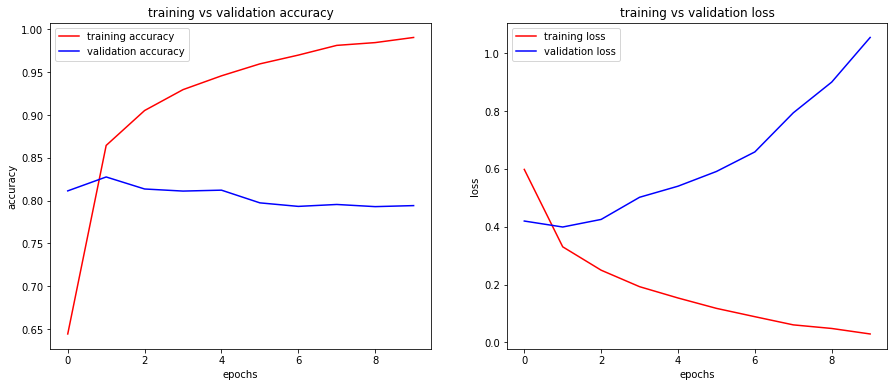

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()

## **LSTM RNN** with Embedding 

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  # Bidirectional LSTM of 32 'time-steps' -> this will give 128 units because it's bidirectional.  No need to flatten afterwards!!!
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')  # it's a binary classification problem
])

model.summary()


from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.99
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()


history = model.fit(train_padded, training_labels_final, epochs=10, callbacks=[callback], validation_data=(test_padded, testing_labels_final), verbose=2)

Epoch 1/10
782/782 - 16s - loss: 0.5572 - accuracy: 0.7002 - val_loss: 0.4798 - val_accuracy: 0.7896
Epoch 2/10
782/782 - 15s - loss: 0.4182 - accuracy: 0.8176 - val_loss: 0.4248 - val_accuracy: 0.8145
Epoch 3/10
782/782 - 15s - loss: 0.2957 - accuracy: 0.8828 - val_loss: 0.4017 - val_accuracy: 0.8188
Epoch 4/10
782/782 - 15s - loss: 0.2475 - accuracy: 0.9082 - val_loss: 0.4721 - val_accuracy: 0.8126
Epoch 5/10
782/782 - 15s - loss: 0.2116 - accuracy: 0.9244 - val_loss: 0.4560 - val_accuracy: 0.8140
Epoch 6/10
782/782 - 15s - loss: 0.1747 - accuracy: 0.9402 - val_loss: 0.5912 - val_accuracy: 0.7734
Epoch 7/10
782/782 - 15s - loss: 0.1487 - accuracy: 0.9509 - val_loss: 0.5809 - val_accuracy: 0.8065
Epoch 8/10
782/782 - 15s - loss: 0.1284 - accuracy: 0.9591 - val_loss: 0.6223 - val_accuracy: 0.7992
Epoch 9/10
782/782 - 15s - loss: 0.1220 - accuracy: 0.9612 - val_loss: 0.6148 - val_accuracy: 0.7978
Epoch 10/10
782/782 - 15s - loss: 0.1092 - accuracy: 0.9662 - val_loss: 0.7107 - val_accura

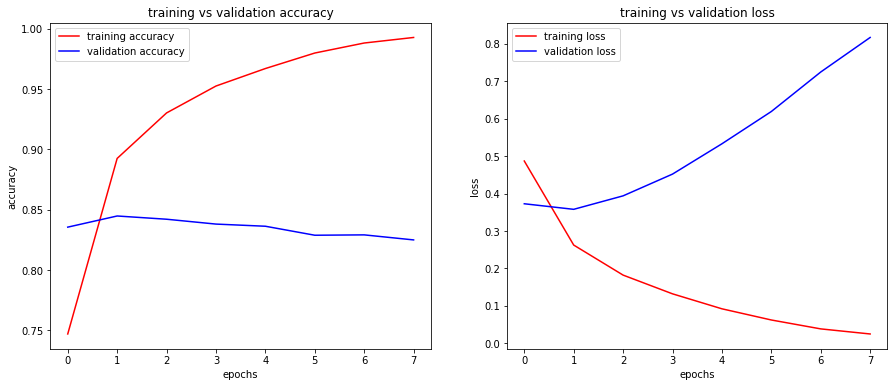

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()

## **1D CNN** with Embedding 

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                             tf.keras.layers.Conv1D(32,5, activation='relu'),   # Convolutional layer to take filters of 5 words from each sentence.
                             tf.keras.layers.GlobalAveragePooling1D(),  # we need to flatten the convolution
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')  # it's a binary classification problem
])

model.summary()


from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 32)           2592      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 162,797
Trainable params: 162,797
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the NN:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.99
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()


history = model.fit(train_padded, training_labels_final, epochs=10, callbacks=[callback], validation_data=(test_padded, testing_labels_final), verbose=2)

Epoch 1/10
782/782 - 6s - loss: 0.4524 - accuracy: 0.7863 - val_loss: 0.3774 - val_accuracy: 0.8327
Epoch 2/10
782/782 - 5s - loss: 0.2816 - accuracy: 0.8833 - val_loss: 0.3941 - val_accuracy: 0.8278
Epoch 3/10
782/782 - 5s - loss: 0.2318 - accuracy: 0.9082 - val_loss: 0.4216 - val_accuracy: 0.8245
Epoch 4/10
782/782 - 5s - loss: 0.1953 - accuracy: 0.9251 - val_loss: 0.4706 - val_accuracy: 0.8144
Epoch 5/10
782/782 - 5s - loss: 0.1698 - accuracy: 0.9377 - val_loss: 0.5269 - val_accuracy: 0.8077
Epoch 6/10
782/782 - 5s - loss: 0.1441 - accuracy: 0.9504 - val_loss: 0.5670 - val_accuracy: 0.8085
Epoch 7/10
782/782 - 5s - loss: 0.1212 - accuracy: 0.9593 - val_loss: 0.6362 - val_accuracy: 0.8012
Epoch 8/10
782/782 - 5s - loss: 0.1008 - accuracy: 0.9690 - val_loss: 0.6906 - val_accuracy: 0.8018
Epoch 9/10
782/782 - 5s - loss: 0.0831 - accuracy: 0.9756 - val_loss: 0.7820 - val_accuracy: 0.7950
Epoch 10/10
782/782 - 5s - loss: 0.0686 - accuracy: 0.9805 - val_loss: 0.9341 - val_accuracy: 0.7866

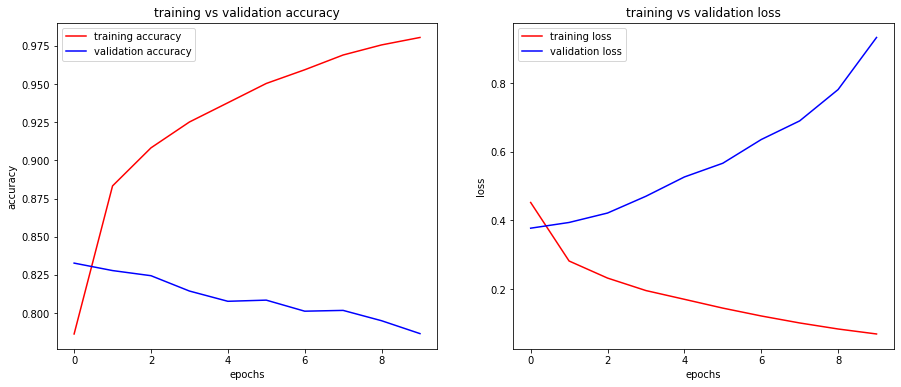

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()